In [1]:
from typing import List
from colorama import Fore
from haystack import Pipeline, component
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator

/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/haystack_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@component
class EntitiesValidator:

    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

In [3]:
entities_validator = EntitiesValidator()
entities_validator.run(replies= ["{'name': 'Tuana'}"])

Reflecting on entities
 {'name': 'Tuana'}


{'entities_to_validate': "{'name': 'Tuana'}"}

In [4]:
entities_validator.run(replies= ["DONE {'name': 'Tuana'}"])

{'entities': " {'name': 'Tuana'}"}

In [5]:
template = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate[0] }}
    Are these the correct entities? 
    Things to check for:
    - Entity categories should exactly be "Person", "Location" and "Date"
    - There should be no extra categories
    - There should be no duplicate entities
    - If there are no appropriate entities for a category, the category should have an empty list
    If you are done say 'DONE' and return your new entities in the next line
    If not, simply return the best entities you can come up with.
    Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    If there are no possibilities for a particular category, return an empty list for this
    category
    Entities:
{% endif %}
"""

In [ ]:
from haystack_integrations.components.generators.ollama import OllamaGenerator

llm = OllamaGenerator(model="llama3.1:latest",
                            url = "http://localhost:11434",
                            generation_kwargs={
                              #"num_predict": 100,
                             # "temperature": 0.9,
                              })

In [6]:
prompt_template = PromptBuilder(template=template)


entities_validator = EntitiesValidator()

self_reflecting_agent = Pipeline(max_loops_allowed=5)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")


🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: OllamaGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

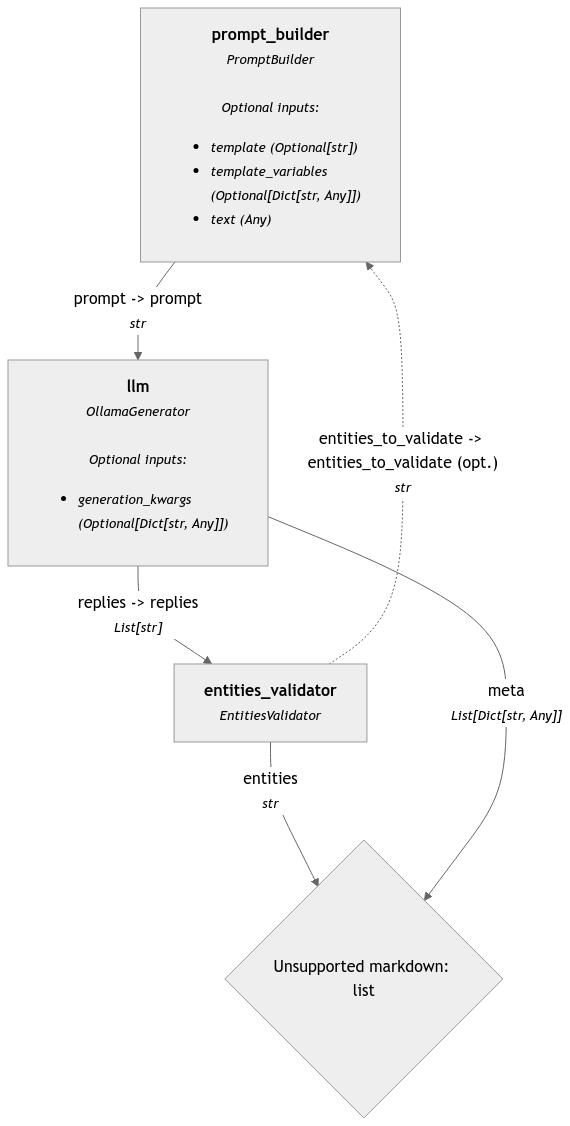

In [7]:
self_reflecting_agent.show()

In [8]:
text = """
Istanbul is the largest city in Turkey, straddling the Bosporus Strait, 
the boundary between Europe and Asia. It is considered the country's economic, 
cultural and historic capital. The city has a population of over 15 million residents, 
comprising 19% of the population of Turkey,[4] and is the most populous city in Europe 
and the world's fifteenth-largest city."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 Here is the extraction of entities from the text:

```
{
  "Person": [],
  "Location": [
    "Istanbul",
    "Turkey",
    "Europe",
    "Asia"
  ],
  "Organization": [],
  "Date": [],
  "City": [
    "Istanbul",
    "Ankara" (Note: Ankara is not mentioned in the text, but it's a city in Turkey)
  ],
  "Percentage": ["19%"],
  "Number": [
    "15 million",
    "15th"
  ]
}
```

However, since you asked for key-value pairs and not just the entities themselves, here is the JSON object:

```
{
  "Person": [],
  "Location": [
    {"name": "Istanbul"},
    {"name": "Turkey"}
  ],
  "Organization": [],
  "Date": [],
  "City": [],
  "Percentage": [
    {"value": "19%"}
  ],
  "Number": [
    {"value": "15 million"},
    {"value": "15th"}
  ]
}
```

Note: I added a name field for the Location entities and value fields for the Percentage and Number entities, as per your request.
Reflecting on entities
 Based on the provided text, I've re-extracted the entities. Here are 